In [1]:
import jax
jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import numpy as np 
import s2scat 
import s2fft
import s2wav

In [2]:
L = 16
N = 3
reality = False
flm = jnp.array(np.random.randn(L, 2*L-1) + 1j*np.random.randn(L, 2*L-1))
filters = s2wav.filters.filters_directional_vectorised(L, N)[0]

In [3]:
precomps_matrices = s2scat.utility.kernels.generate_precompute_matrices(L,N)

In [4]:
recursive_matrices = s2scat.utility.kernels.generate_recursive_matrices(L, N)

In [5]:
coeffs_recursive= s2scat.core.scatter.directional(
    flm, 
    L, 
    N, 
    filters=filters,
    precomps=recursive_matrices,
    recursive=True
)

In [6]:
coeffs_precompute = s2scat.core.scatter.directional(
    flm, 
    L, 
    N, 
    filters=filters,
    precomps=precomps_matrices,
    recursive=False
)

In [7]:
coeffs_c_backend = s2scat.core.scatter.directional_c(flm, L, N, filters=filters)

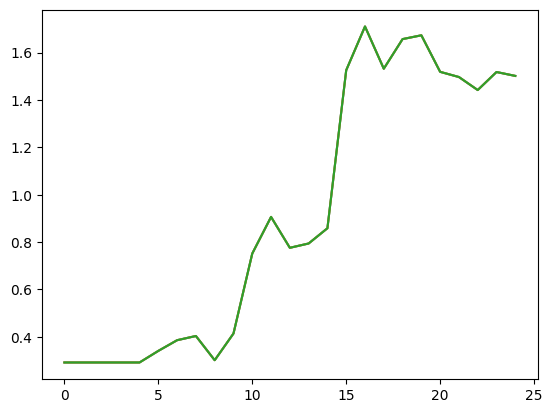

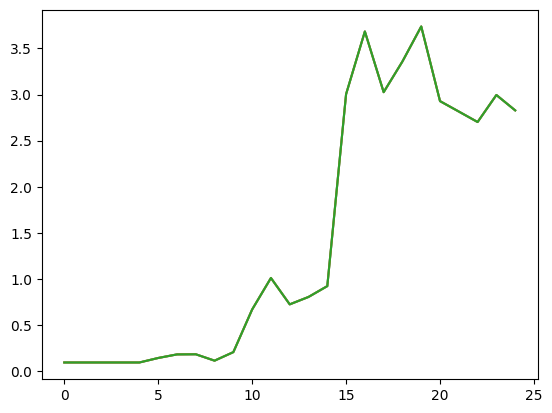

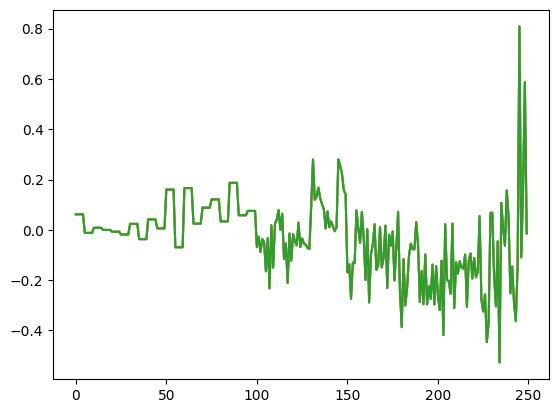

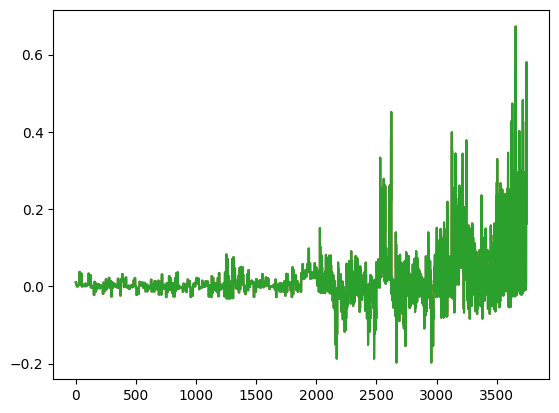

In [8]:
from matplotlib import pyplot as plt 
for i in range(2,6):
    plt.plot(coeffs_recursive[i])
    plt.plot(coeffs_precompute[i])
    plt.plot(coeffs_c_backend[i])
    plt.show()

In [9]:
from jax import grad 

def rec_func(flm):
    coeffs = s2scat.core.scatter.directional(
        flm, 
        L, 
        N, 
        filters=filters,
        precomps=recursive_matrices,
        recursive=True
    )
    loss = 0 
    for i in range(6):
        loss += jnp.mean(jnp.abs(coeffs[i]))
    return loss

def pre_func(flm):
    coeffs = s2scat.core.scatter.directional(
        flm, 
        L, 
        N, 
        filters=filters,
        precomps=precomps_matrices,
        recursive=False
    )
    loss = 0 
    for i in range(6):
        loss += jnp.mean(jnp.abs(coeffs[i]))
    return loss

def c_func(flm):
    coeffs = s2scat.core.scatter.directional_c(flm, L, N, filters=filters)
    loss = 0 
    for i in range(6):
        loss += jnp.mean(jnp.abs(coeffs[i]))
    return loss


In [10]:
grad_rec_func = grad(rec_func)
grad_pre_func = grad(pre_func)
grad_c_func = grad(c_func)

In [11]:
print("starting gr")
gr = grad_rec_func(flm)
print("starting gp")
gp = grad_pre_func(flm)
print("starting gc")
gc = grad_c_func(flm)

starting gr
starting gp
starting gc


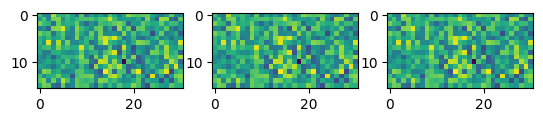

In [12]:
from matplotlib import pyplot as plt 
mx, mn = np.nanmax(np.real(gr)), np.nanmin(np.real(gr))
fig, (ax1,ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.real(gr), vmax=mx, vmin=mn)
ax2.imshow(np.real(gp), vmax=mx, vmin=mn)
ax3.imshow(np.real(gc), vmax=mx, vmin=mn)
plt.show()


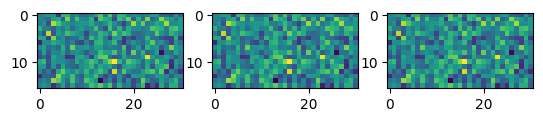

In [13]:
from matplotlib import pyplot as plt 
mx, mn = np.nanmax(np.imag(gr)), np.nanmin(np.imag(gr))
fig, (ax1,ax2, ax3) = plt.subplots(1,3)
ax1.imshow(np.imag(gr), vmax=mx, vmin=mn)
ax2.imshow(np.imag(gp), vmax=mx, vmin=mn)
ax3.imshow(np.imag(gc), vmax=mx, vmin=mn)
plt.show()